Universidad Torcuato Di Tella

Metodos computacionales\
**Trabajo Práctico 1:
Resoluciones Numéricas de Ecuaciones Diferenciales**

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def condicion_inicial(x):
    if 0 <= x and x < 0.25:
        return 4.0*x
    elif 0.25 <= x and x < 0.50:
        return -2.0*x + 1.5
    elif 0.50 <= x and x < 0.75:
        return 2.0*x - 0.5
    elif 0.75 <= x and x <= 1.00:
        return -4.0*x + 4.0
    else:
        print("x tiene que tenr un valor entre 0 y 1")
                       


def e_c_metodoexplicito(alpha, funcion, dx, dt, T):
    N  = int(round(1.0/dx)) # N son las columnas
    M = int(round(T/dt)) # M son las filas 
    x = np.arange(0, 1+dx, dx, dtype = float)
    t = np.arange(0, T+dt, dt, dtype = float)
    matriz_u = np.zeros((M+1, N+1), dtype = float)
    r  = alpha * dt / (dx**2)
    y = np.zeros(N+1)
    for pos in range(N+1):
        y[pos] =funcion(x[pos]) 
    matriz_u[0, :] = y # la primero fila se llena con la condicion inicial
    A = np.zeros((N-1, N-1))
    for a in range(N-1):
        A[a, a] = 1 - 2*r
        if a > 0:
            A[a, a-1] = r
        if a < N-2:
            A[a, a+1] = r

    for n in range(M): #las filas 
        x_vec = matriz_u[n, 1:N] #b es la fila i seleccionando todos los elementos excepto el primer elmento  y el ultimo por las condiciones de borde 
        b = A.dot(x_vec) 
        matriz_u[n+1, 1:N] = b
    return matriz_u, x, t, y, r

def e_c_metodoimplicito(alpha, funcion, dx, dt, T):
    N  = int(round(1.0/dx))
    M = int(round(T/dt))
    x = np.arange(0, 1+dx, dx, dtype = float)
    t = np.arange(0, T+dt, dt, dtype = float)
    matriz_u = np.zeros((M+1, N+1), dtype = float)
    r  = alpha * dt / (dx**2)
    y = np.zeros(N+1)
    for pos in range(N+1):
        y[pos] =funcion(x[pos]) 
    matriz_u[0, :] = y # la primero fila se llena con la condicion inicial
    A = np.zeros((N-1, N-1))
    for a in range(N-1):
        A[a, a] = 1 + 2*r
        if a > 0:
            A[a, a-1] = -r
        if a < N-2:
            A[a, a+1] = -r

    for n in range(M):
        b = matriz_u[n, 1:N] #b es la fila i seleccionando todos los elementos excepto el primer elmento  y el ultimo por las condiciones de borde 

        u_interior = np.linalg.solve(A, b) #resuelve la ecuacion lineal 
        matriz_u[n+1, 1:N] = u_interior

    return matriz_u, x, t,y,r 

In [25]:
alpha = 1.0
dx    = 0.05
dt    = 0.001
T     = 0.1

U_e, x_e, t_e, y_e, r_e = e_c_metodoexplicito(alpha, condicion_inicial, dx, dt, T)
U_i, x_i, t_i, y_i, r_i= e_c_metodoimplicito(alpha, condicion_inicial, dx, dt, T)


In [26]:
from matplotlib.animation import FuncAnimation, PillowWriter

def crear_gif(alpha, funcion, dx, dt, T, nombre_gif):
    u_ex, x_e, t_e, y_e, r = e_c_metodoexplicito(alpha, funcion, dx, dt, T)
    u_im, x_i, t_i, y_i, r= e_c_metodoimplicito(alpha, funcion, dx, dt, T)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    
    # Líneas iniciales
    line_ex, = ax1.plot(x_e, u_ex[0, :], color='blue')
    ax1.set_title("Método Explícito")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1.1*np.max(u_ex))
    ax1.set_xlabel("x")
    ax1.set_ylabel("u(x,t)")
    ax1.grid(True)

    line_im, = ax2.plot(x_i, u_im[0, :], color='red')
    ax2.set_title("Método Implícito")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1.1*np.max(u_ex))
    ax2.set_xlabel("x")
    ax2.set_ylabel("u(x,t)")
    ax2.grid(True)

    # Función que actualiza cada frame
    def actualizar(frame):
        line_ex.set_ydata(u_ex[frame, :])
        ax1.set_title(f"Método Explícito t={t_e[frame]:.3f}")
        line_im.set_ydata(u_im[frame, :])
        ax2.set_title(f"Método Implícito t={t_i[frame]:.3f}")
        return line_ex, line_im

    anim = FuncAnimation(fig, actualizar, frames=len(t_e), interval=100, blit=True)
    anim.save(nombre_gif, writer=PillowWriter(fps=5))
    print(f"GIF guardado como {nombre_gif}")



GIF guardado como Implicito_Explicito_calor.gif


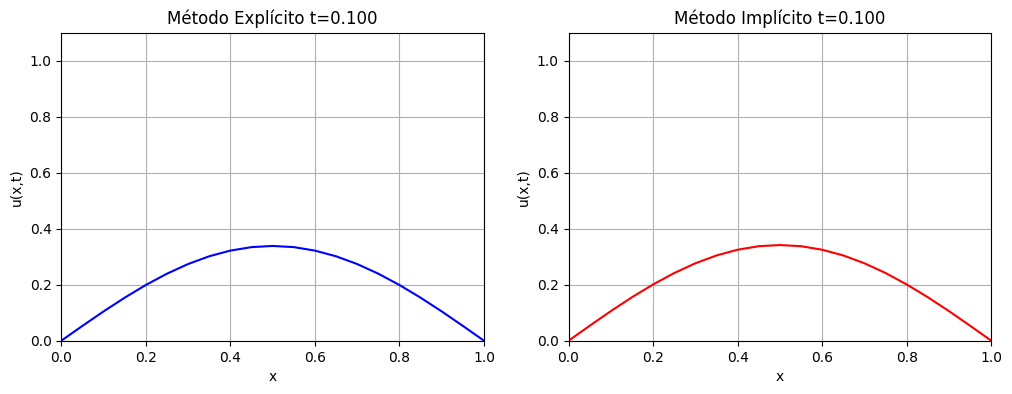

In [27]:
crear_gif(alpha, condicion_inicial, dx, dt, T, "Implicito_Explicito_calor.gif")


GIF guardado como 1.0alpha_Implicito_Explicito_calor.gif


C:\Users\lumil\AppData\Local\Temp\ipykernel_10116\3013812178.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, datos], ignore_index=True)


GIF guardado como 1.1alpha_Implicito_Explicito_calor.gif
GIF guardado como 1.2alpha_Implicito_Explicito_calor.gif
GIF guardado como 1.3alpha_Implicito_Explicito_calor.gif
GIF guardado como 1.4alpha_Implicito_Explicito_calor.gif
GIF guardado como 1.5alpha_Implicito_Explicito_calor.gif


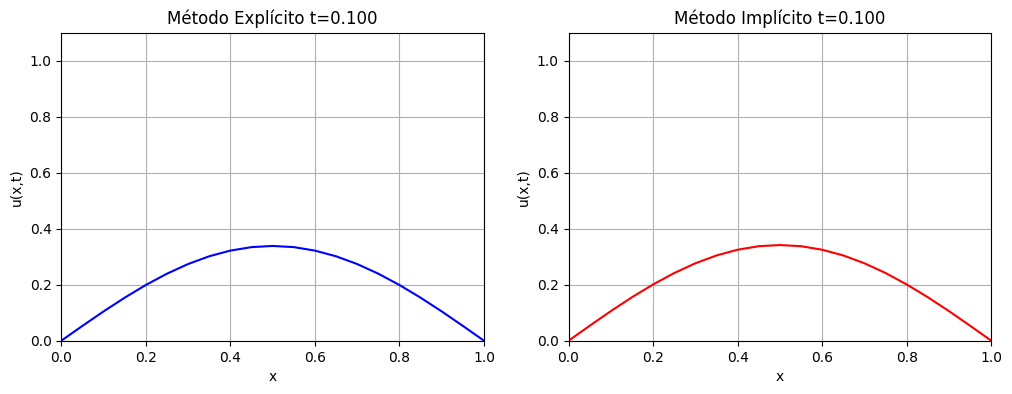

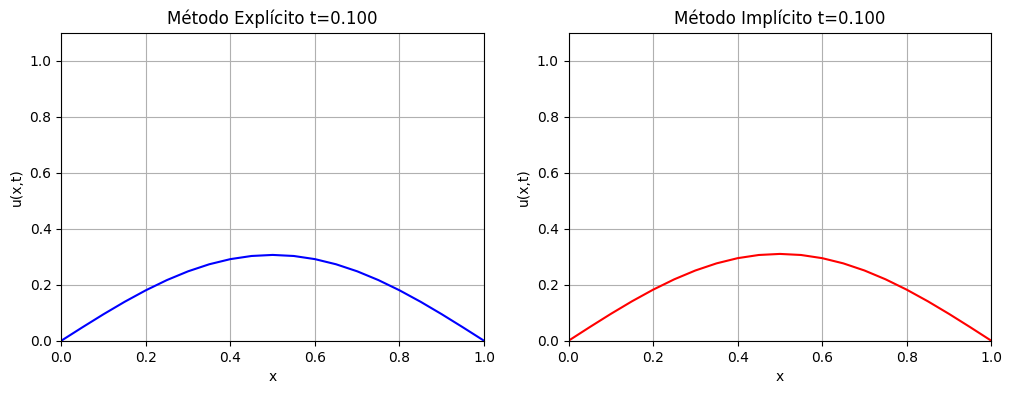

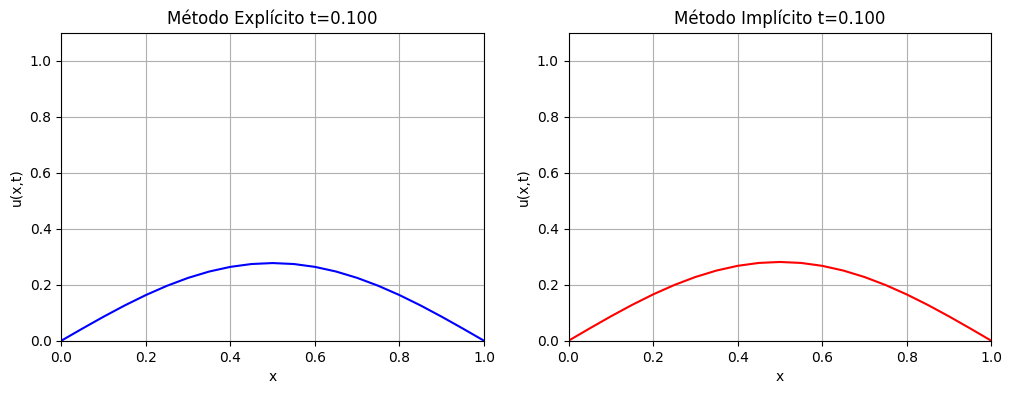

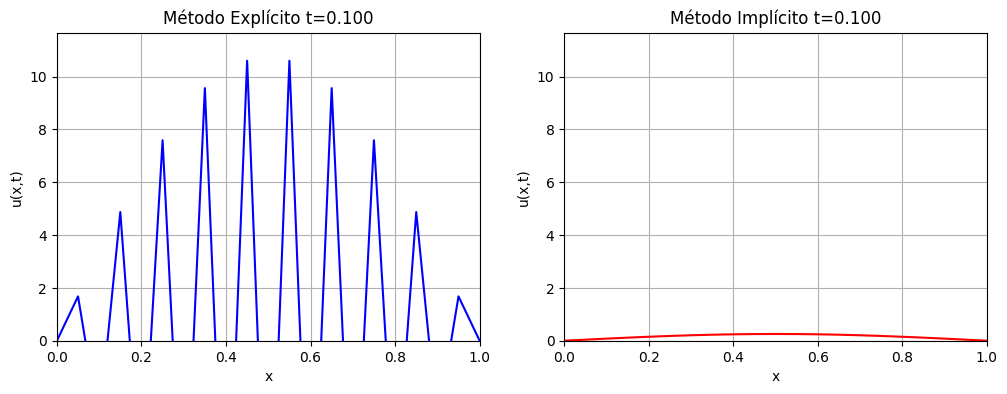

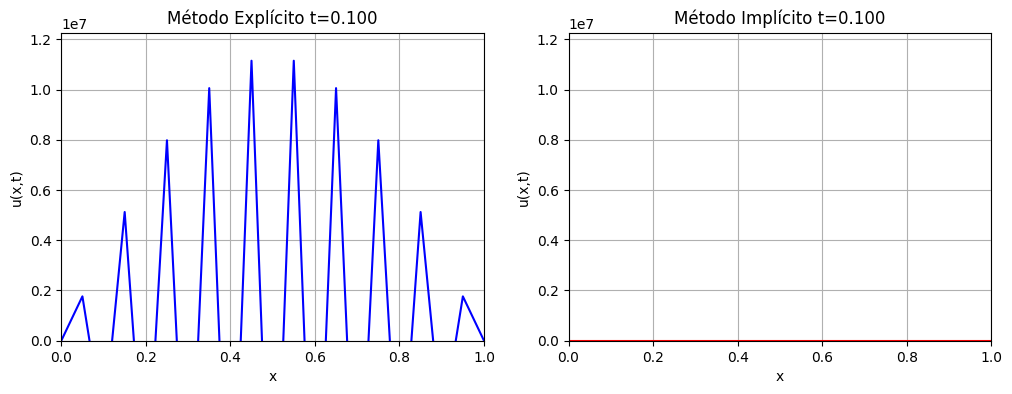

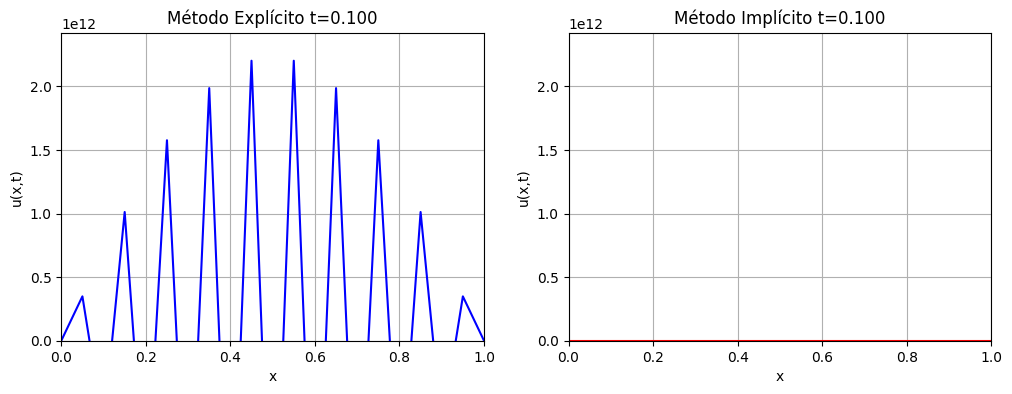

In [28]:
df= pd.DataFrame(columns=["alpha", "r_explicito", "r_implicito"])
t = np.arange(1.0, 2.1, 0.1, dtype = float)
for i in [1.0,1.1,1.2, 1.3,1.4,1.5]:
    U_e, x_e, t_e, y_e, r_e = e_c_metodoexplicito(i, condicion_inicial, dx, dt, T)
    U_i, x_i, t_i, y_i, r_i= e_c_metodoimplicito(i, condicion_inicial, dx, dt, T)
    crear_gif(i, condicion_inicial, dx, dt, T, f"{i}alpha_Implicito_Explicito_calor.gif")
    datos = pd.DataFrame([{"alpha": i, "r_explicito":r_e, "r_implicito":r_i}])
    df = pd.concat([df, datos], ignore_index=True)
    

In [29]:
df

,alpha,r_explicito,r_implicito
0,1.0,0.40,0.40
1,1.1,0.44,0.44
2,1.2,0.48,0.48
3,1.3,0.52,0.52
4,1.4,0.56,0.56
5,1.5,0.60,0.60
